In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [18]:
data = np.zeros((2,11, 1200, 1920))
data[0] = np.load('Data_Britta/OD_ft_flatfield.npy')
data[1] = np.load('Data_Britta/OD_ft_manual.npy')

shape = np.shape(data)

In [24]:
def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.5,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog(2, res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **(3/2)
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)
    return amplitude * np.where(res > 0, res, 0)
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))


def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigmax_th=1.0, sigmay_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigmax_th, sigmay=sigmay_th)

In [17]:
sigma = 0.4
blurred = gaussian_filter(data, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)
        print(np.sum(thresh[i,j]))
center = calc_cen_bulk(thresh)
print(np.shape(thresh))
BEC_width_guess = guess_BEC_width(thresh, center)

2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
2304000.0
(2, 11, 1200, 1920)


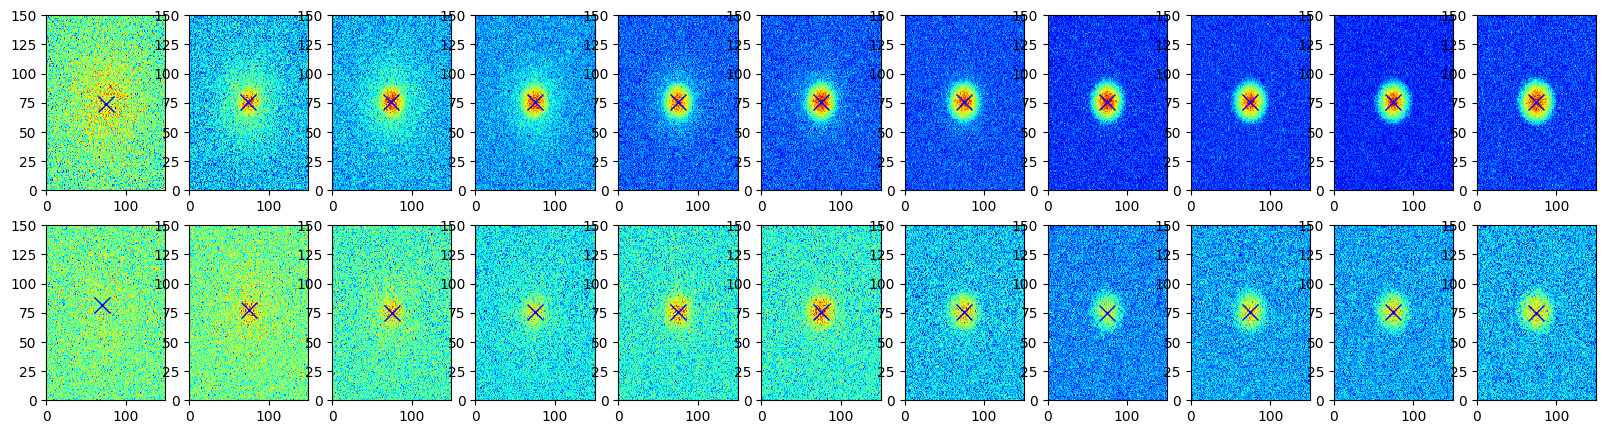

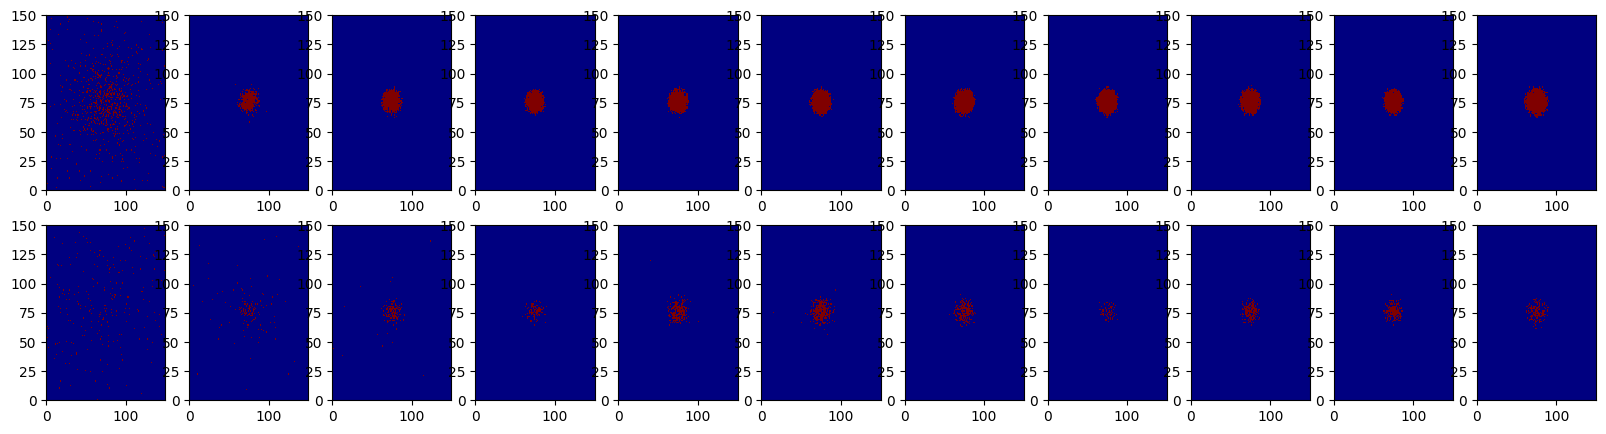

In [32]:
fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(cropOD[i,j], cmap='jet')
        ax[i,j].plot(center[i,j,0], center[i,j,1], marker='x', color='b', markersize=12)
plt.show()

fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(thresh[i,j], cmap='jet')
plt.show()


In [30]:
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], 150, 150))

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        cropOD[i,j] = data[i,j, round(center[i,j,1]-75):round(center[i,j,1]+75), round(center[i,j,0]-75):round(center[i,j,0]+75)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
print(center)

[[[75.43843844 74.33233233]
  [74.49700599 75.66467066]
  [74.20763723 75.66109785]
  [74.70685579 75.38534279]
  [74.58390805 75.63678161]
  [74.44421488 75.28099174]
  [74.56997972 75.31845842]
  [74.41902834 75.50404858]
  [74.36344538 75.48739496]
  [74.44730679 75.54332553]
  [74.6125     75.37321429]]

 [[70.24350649 81.52272727]
  [75.33898305 77.08474576]
  [74.57142857 75.00571429]
  [75.12068966 75.64655172]
  [74.47509579 75.85823755]
  [74.67948718 75.84615385]
  [74.9796748  75.65447154]
  [75.30769231 75.05494505]
  [74.69072165 75.39175258]
  [75.11167513 75.88324873]
  [74.90547264 75.09452736]]]


In [33]:
BEC_width_guess = guess_BEC_width(thresh, center)

print(BEC_width_guess)

[[[17. 18.]
  [19. 18.]
  [24. 20.]
  [26. 23.]
  [26. 19.]
  [28. 23.]
  [26. 22.]
  [26. 25.]
  [25. 22.]
  [25. 20.]
  [30. 25.]]

 [[ 4.  3.]
  [ 7.  8.]
  [ 7. 14.]
  [10.  4.]
  [15. 13.]
  [22. 17.]
  [15. 15.]
  [ 7.  4.]
  [13. 12.]
  [19. 15.]
  [14. 12.]]]
